<a href="https://colab.research.google.com/github/nmningmei/simple_tensorflow_logistic_regression_classifier/blob/main/customized_training_with_noise_instances_(fMRI_data_example).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This script adapts from [Customizing what happens in fit()](https://keras.io/guides/customizing_what_happens_in_fit/) for particular use in our lab

In [ ]:
import os
if not os.path.exists("/content/simple_tensorflow_logistic_regression_classifier"):
    !git clone https://github.com/nmningmei/simple_tensorflow_logistic_regression_classifier.git

os.chdir("/content/simple_tensorflow_logistic_regression_classifier")

# Upload the data

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_dictionary = {'test.csv':'1ZNryNfmV3S3W66JfFo9n-NWfazVz2idW',
                   'test.npy':'1Uytrqj8biQGq-w0VbFJxm7xOH52Cra-Z',
                   'train.csv':'1C9JFuZkmcRAan56LBrDYtLdfq_iPRO7j',
                   'train.npy':'1ra9oL-9Mdy6elcnW6daeK0esGHeyGfe0'}
for file_name,file_id in file_dictionary.items():
    downloaded = drive.CreateFile({'id':file_id})
    downloaded.GetContentFile(file_name)

In [ ]:
ls

customized_training_with_noise_instances.ipynb              temp.h5   train.csv
LICENSE                                                     test.csv  train.npy
README.md                                                   test.npy  utils.py
simple_logistic_regression_implemented_in_tensorflow.ipynb  test.py


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,initializers,optimizers,losses,metrics
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

# experiment control

In [ ]:
n_epochs = int(1e3) # just a large number
print_train = True
batch_size = 8
n_noise = 1 # number of noise inputs per epoch
learning_rate = 1e-2
tol = 1e-4
patience = 10

# clear memory states

In [ ]:
tf.keras.backend.clear_session()

# 0: nonliving, 1: living, 2: noise

In [ ]:
def load_data(exclude = None):
    X_train = np.load('train.npy')
    df_train = pd.read_csv('train.csv')
    y_train = df_train['target_category'].values
    X_test = np.load('test.npy')
    df_test = pd.read_csv('test.csv')
    y_test = df_test['target_category'].values
    if exclude is not None:
        idx_train = y_train != exclude

        X_train = X_train[idx_train]
        y_train = y_train[idx_train]
    return X_train,y_train,X_test,y_test
X_train,y_train,X_test,y_test = load_data(exclude = 2)

# One-hot encoding for softmax

In [ ]:
def one_hot_encoding(y):
    y = np.array(y == 0,dtype = 'float32')
    y = y.reshape((-1,1))
    y = np.hstack([y,1-y]).astype('float32')
    return y
y_train = one_hot_encoding(y_train)
y_test = one_hot_encoding(y_test)

# split the data into train, validation, and test

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size = .1,random_state = 12345)

# build the model

## Helper functions

In [ ]:
class simple_logistic_regression(keras.Model):
    def train_step(self, data):
        """
        This function is used during `fit()`

        We manually add noise instances in each batch of training to increase
        the diversity of the noise that the model sees.
        """
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        x_mean,x_std = tf.nn.moments(x,axes = 0)
        with tf.GradientTape() as tape:
            x_noise = tf.random.normal(shape = (n_noise,x.shape[1]),
                                       mean = x_mean,
                                       stddev = x_std,
                                       name = 'x_noise')
            y_noise = tf.constant([[0.5,0.5]] * n_noise,dtype = "float32")
            x_train = tf.concat([x,x_noise],0)
            y_train = tf.concat([y,y_noise],0)
            idx = np.arange(x_train.shape[0])
            np.random.shuffle(idx)
            x_train = tf.gather(x_train,idx,axis = 0)
            y_train = tf.gather(y_train,idx,axis = 0)
            y_pred = self(x_train, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y_train, y_pred, 
                                      regularization_losses = self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y_train, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    def test_step(self, data):
        """
        We must have the testing function to avoid double dipping in testing
        """
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
def build_model(input_size,output_size = 2,kernel_regularizer = None,activity_regularizer = None):
    """
    This function builds the logistic regression classifier using the customized
    modeling building method we define above

    Inputs
    ---
    input_size: int, the 2nd dimension of the input features
    output_size: int, default = 2
    kernel_regularizer: None or keras.regularizers
    activity_regularizer: None or keras.regularizers

    Outputs
    ---
    model: keras.Models
    """
    tf.random.set_seed(12345)
    input_layer = layers.Input(shape        = (input_size,),
                                name         = "input_layer",)

    logistic_layer = layers.Dense(units                 = output_size,
                                  activation            = 'softmax',
                                  use_bias              = True,
                                  kernel_initializer    = initializers.HeNormal(),
                                  kernel_regularizer    = kernel_regularizer,
                                  activity_regularizer  = activity_regularizer,
                                  name                  = 'logistic_layer'
                                  )(input_layer)
    model = simple_logistic_regression(input_layer,logistic_layer,
                                       name = 'logistic_regression')
    return model
# the most important helper function: early stopping and model saving
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    
    """
    Make call back function lists for the keras models
    
    Parameters
    -------------------------
    model_name : str,
        directory of where we want to save the model and its name
    monitor : str, default = 'val_loss'
        the criterion we used for saving or stopping the model
    mode : str, default = 'min'
        min --> lower the better, max --> higher the better
    verboser : int or bool, default = 0
        printout the monitoring messages
    min_delta : float, default = 1e-4
        minimum change for early stopping
    patience : int, default = 50
        temporal windows of the minimum change monitoring
    frequency : int, default = 1
        temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint : tensorflow.keras.callbacks
        saving the best model
    EarlyStopping : tensorflow.keras.callbacks
        early stoppi
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
                                 verbose          = verbose,# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose, 
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]
def compile_logistic_regression(
                    model,
                    model_name      = 'temp.h5',
                    optimizer       = None,
                    loss_function   = None,
                    metric          = None,
                    callbacks       = None,
                    learning_rate   = 1e-2,
                    tol             = 1e-4,
                    patience        = 5,
                    ):
    """
    Inputs
    ---
    model: tf.keras.models.Model or callable tf objects
    model_name: str, directory of where we want to save the model and its name
    optimizer: None or tf.keras.optimizers, default = SGD
    loss_function: None or tf.keras.losses, default = BinaryCrossentropy
    metric: None or tf.keras.metrics, default = AUC
    callbacks: None or list of tf.keras.callbacks, default = [checkpoint,earlystopping]
    learning_rate: float, learning rate, default = 1e-2,
    tol: float, for determining when to stop training, default = 1e-4,
    patience: int, for determing when to stop training, default = 5,
    
    Outputs
    ---
    model: tf.keras.models.Model or callable tf objects
    callbacks:ist of tf.keras.callbacks
    """
    if optimizer is None:
        optimizer       = optimizers.SGD(learning_rate = learning_rate,)
    if loss_function is None:
        loss_function   = losses.BinaryCrossentropy()
    if metric is None:
        metric          = metrics.AUC()
    if callbacks is None:
        callbacks       = make_CallBackList(
                                      model_name    = model_name,
                                      monitor       = 'val_loss',
                                      mode          = 'min',
                                      verbose       = 0,
                                      min_delta     = tol,
                                      patience      = patience,
                                      frequency     = 1,
                                      )
    model.compile(optimizer = optimizer,
                  loss      = loss_function,
                  metrics   = [metric],
                  run_eagerly = True,
                  )
    return model,callbacks

## Use the helper functions to build the models

In [ ]:
logistic_regression_model = build_model(input_size = X_train.shape[1],output_size = 2,)
logistic_regression_model,callbacks = compile_logistic_regression(logistic_regression_model,
                                                                  learning_rate = learning_rate,
                                                                  tol = tol,
                                                                  patience = patience,
                                                                  )

## Train

In [ ]:
logistic_regression_model.fit(X_train,y_train,
                              batch_size = batch_size,
                              validation_data = (X_valid,y_valid),
                              epochs = n_epochs,
                              callbacks = callbacks,
                              shuffle = True,
                              )

Epoch 1/1000
53/53 [==============================] - 1s 26ms/step - loss: 0.4295 - auc: 0.9219 - val_loss: 0.2978 - val_auc: 0.9507
Epoch 2/1000
53/53 [==============================] - 1s 24ms/step - loss: 0.3195 - auc: 0.9664 - val_loss: 0.2757 - val_auc: 0.9647
Epoch 3/1000
53/53 [==============================] - 1s 22ms/step - loss: 0.2242 - auc: 0.9801 - val_loss: 0.2553 - val_auc: 0.9638
Epoch 4/1000
53/53 [==============================] - 1s 21ms/step - loss: 0.2272 - auc: 0.9824 - val_loss: 0.2939 - val_auc: 0.9570
Epoch 5/1000
53/53 [==============================] - 1s 21ms/step - loss: 0.2552 - auc: 0.9830 - val_loss: 0.2500 - val_auc: 0.9606
Epoch 6/1000
53/53 [==============================] - 1s 18ms/step - loss: 0.2130 - auc: 0.9855 - val_loss: 0.2397 - val_auc: 0.9597
Epoch 7/1000
53/53 [==============================] - 1s 18ms/step - loss: 0.1925 - auc: 0.9843 - val_loss: 0.2363 - val_auc: 0.9602
Epoch 8/1000
53/53 [==============================] - 1s 21ms/step - 

## Predict

## Predict on random data

In [ ]:
X_train,y_train,X_test,y_test = load_data(exclude = None)
X_noise = X_test.copy()

In [ ]:
y_noise_pred = logistic_regression_model.predict(X_noise)

(array([479.,  86.,  53.,  43.,  43.,  45.,  57.,  45.,  78., 476.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

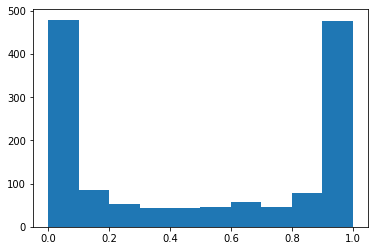

In [ ]:
plt.hist(y_noise_pred[:,-1])

# train the model without using the Gaussian noise samples

In [ ]:
X_train,y_train,X_test,y_test = load_data(exclude = None)
label_maps = {0:[1,0],
              1:[0,1],
              2:[0.5,0.5]}
y_train = np.array([label_maps[item] for item in y_train])
y_test = np.array([label_maps[item] for item in y_test])
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size = .1,random_state = 12345)
def build_model(input_size,output_size = 2,kernel_regularizer = None,activity_regularizer = None):
    """
    This function builds the logistic regression classifier using the customized
    modeling building method we define above

    Inputs
    ---
    input_size: int, the 2nd dimension of the input features
    output_size: int, default = 2
    kernel_regularizer: None or keras.regularizers
    activity_regularizer: None or keras.regularizers

    Outputs
    ---
    model: keras.Models
    """
    tf.random.set_seed(12345)
    input_layer = layers.Input(shape        = (input_size,),
                                name         = "input_layer",)

    logistic_layer = layers.Dense(units                 = output_size,
                                  activation            = 'softmax',
                                  use_bias              = True,
                                  kernel_initializer    = initializers.HeNormal(),
                                  kernel_regularizer    = kernel_regularizer,
                                  activity_regularizer  = activity_regularizer,
                                  name                  = 'logistic_layer'
                                  )(input_layer)
    model = models.Model(input_layer,logistic_layer,name = 'logistic_regression')
    return model
# the most important helper function: early stopping and model saving
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    
    """
    Make call back function lists for the keras models
    
    Parameters
    -------------------------
    model_name : str,
        directory of where we want to save the model and its name
    monitor : str, default = 'val_loss'
        the criterion we used for saving or stopping the model
    mode : str, default = 'min'
        min --> lower the better, max --> higher the better
    verboser : int or bool, default = 0
        printout the monitoring messages
    min_delta : float, default = 1e-4
        minimum change for early stopping
    patience : int, default = 50
        temporal windows of the minimum change monitoring
    frequency : int, default = 1
        temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint : tensorflow.keras.callbacks
        saving the best model
    EarlyStopping : tensorflow.keras.callbacks
        early stoppi
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
                                 verbose          = verbose,# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose, 
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]
logistic_regression_model = build_model(input_size = X_train.shape[1],output_size = 2,)
logistic_regression_model,callbacks = compile_logistic_regression(logistic_regression_model,
                                                                  learning_rate = learning_rate,
                                                                  tol = tol,
                                                                  patience = patience,
                                                                  )
logistic_regression_model.fit(X_train,y_train,
                              batch_size = batch_size,
                              validation_data = (X_valid,y_valid),
                              epochs = n_epochs,
                              callbacks = callbacks,
                              shuffle = True,
                              )

Epoch 1/1000
79/79 [==============================] - 2s 19ms/step - loss: 0.6566 - auc_1: 0.8424 - val_loss: 0.8525 - val_auc_1: 0.8048
Epoch 2/1000
79/79 [==============================] - 1s 18ms/step - loss: 0.4498 - auc_1: 0.9382 - val_loss: 0.4692 - val_auc_1: 0.9546
Epoch 3/1000
79/79 [==============================] - 1s 18ms/step - loss: 0.3391 - auc_1: 0.9773 - val_loss: 0.4321 - val_auc_1: 0.9746
Epoch 4/1000
79/79 [==============================] - 1s 19ms/step - loss: 0.3069 - auc_1: 0.9897 - val_loss: 0.4259 - val_auc_1: 0.9801
Epoch 5/1000
79/79 [==============================] - 1s 17ms/step - loss: 0.2828 - auc_1: 0.9966 - val_loss: 0.4145 - val_auc_1: 0.9822
Epoch 6/1000
79/79 [==============================] - 1s 18ms/step - loss: 0.2712 - auc_1: 0.9987 - val_loss: 0.4206 - val_auc_1: 0.9773
Epoch 7/1000
79/79 [==============================] - 1s 17ms/step - loss: 0.2644 - auc_1: 0.9993 - val_loss: 0.4256 - val_auc_1: 0.9792
Epoch 8/1000
79/79 [=====================

## Predict

(array([515.,  93.,  63.,  38.,  52.,  48.,  44.,  73.,  71., 408.]),
 array([1.3438657e-17, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

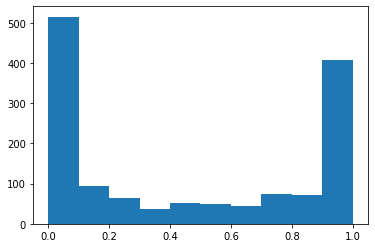

In [ ]:
X_train,y_train,X_test,y_test = load_data(exclude = None)
X_noise = X_test.copy()
y_noise_pred = logistic_regression_model.predict(X_noise)
plt.hist(y_noise_pred[:,-1])